# Predicting Career Shifts using Decision Trees

**Objective**: Predict whether someone is likely to change occupation based on various features.

**Business Questions**:
- What factors most influence career changes?
- How accurate is the model in predicting these changes?

## Dataset Overview

- The dataset contains features like `Industry Growth Rate`, which is ordinal.
- Target variable: **Likely to Change Occupation** (binary classification: Yes/No).

In [347]:
# Importing all necessary libraries
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Loading the dataset
dataset = pd.read_csv('career_change_dataset.csv')

# Handling Ordinal Data
industryRate_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

# Applying the Mappings
dataset['Industry Growth Rate'] = dataset['Industry Growth Rate'].map(industryRate_mapping)

dataset.head()

,Likely to Change Occupation,Geographic Mobility,Professional Networks,Job Satisfaction,Work-Life Balance,Skills Gap,Salary,Job Security,Years of Experience,Age,Job Opportunities,Industry Growth Rate
0,0,1,2,7,10,8,198266,8,7,48,83,2
1,0,1,2,10,3,3,96803,9,26,44,55,0
2,0,0,2,8,3,4,65920,4,27,21,78,0
3,0,0,9,7,9,2,85591,5,14,33,62,1
4,1,0,2,3,1,5,43986,3,0,28,8,0


- **No Missing Data**: All columns have the full **38,444** **non-null** entries, which means the **dataset is complete**.
- **Data Types**: All columns are integers (int64).

In [348]:
# Data types, non-null values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Likely to Change Occupation  38444 non-null  int64
 1   Geographic Mobility          38444 non-null  int64
 2   Professional Networks        38444 non-null  int64
 3   Job Satisfaction             38444 non-null  int64
 4   Work-Life Balance            38444 non-null  int64
 5   Skills Gap                   38444 non-null  int64
 6   Salary                       38444 non-null  int64
 7   Job Security                 38444 non-null  int64
 8   Years of Experience          38444 non-null  int64
 9   Age                          38444 non-null  int64
 10  Job Opportunities            38444 non-null  int64
 11  Industry Growth Rate         38444 non-null  int64
dtypes: int64(12)
memory usage: 3.5 MB


- Most columns have values on a **scale of 1 to 10**, except for continuous variables like `Salary` and `Age`.
- **Industry Growth Rate** has three possible values: **0 (Low)**, **1 (Medium)**, and **2 (High)**.
- The dataset has **no missing values**.

In [349]:
# Statistical summary
dataset.describe()

,Likely to Change Occupation,Geographic Mobility,Professional Networks,Job Satisfaction,Work-Life Balance,Skills Gap,Salary,Job Security,Years of Experience,Age,Job Opportunities,Industry Growth Rate
count,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000,38444.000000
mean,0.576553,0.303975,5.514098,5.489673,5.517012,5.520133,114975.623999,5.481896,19.548200,39.540422,50.308267,1.009780
std,0.494111,0.459978,2.868188,2.870407,2.879007,2.870065,48963.725598,2.870640,11.552474,11.574509,28.877294,0.815343
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,30005.000000,1.000000,0.000000,20.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,72701.500000,3.000000,10.000000,30.000000,25.000000,0.000000
50%,1.000000,0.000000,6.000000,6.000000,6.000000,6.000000,114861.000000,5.000000,20.000000,40.000000,50.000000,1.000000
75%,1.000000,1.000000,8.000000,8.000000,8.000000,8.000000,157241.000000,8.000000,30.000000,50.000000,75.000000,2.000000
max,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,199996.000000,10.000000,39.000000,59.000000,100.000000,2.000000


In [350]:
# Rows and columns
print("Shape of dataset:", dataset.shape) 

Shape of dataset: (38444, 12)


## Visualizing Distribution

**Key Observations:**

1. Many features, such as **Professional Networks**, **Job Satisfaction**, **Work-Life Balance**, **Job Security**, and **Skills Gap**, have evenly distributed values, indicating diverse responses.
2. Binary features like **Likely to Change Occupation** and **Geographic Mobility** show a strong bias toward one category.
3. Continuous variables like **Salary**, **Years of Experience**, **Job Opportunities** and **Age** show an even spread within their ranges, ensuring a representative dataset.
4. Industry-related features, such as **Industry Growth Rate**, have categorical groupings rather than smooth distributions.

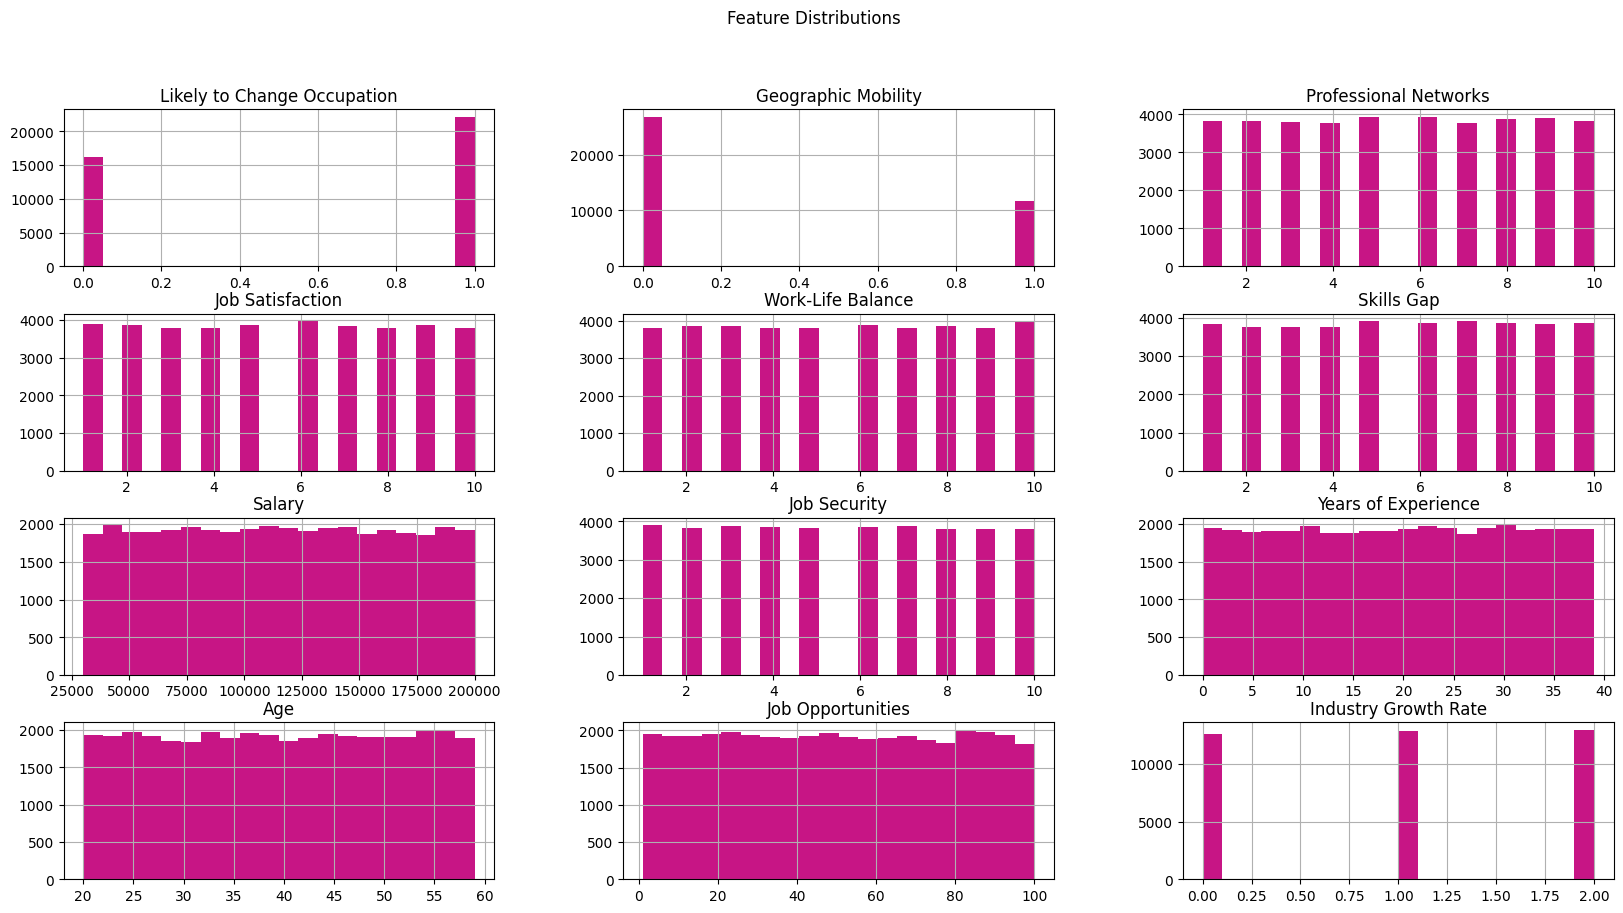

In [351]:
# Visualizing numerical feature distributions
dataset.hist(figsize=(20, 10), bins=20, color='#C71585')
plt.suptitle('Feature Distributions')
plt.show()

# Visualize categorical feature distributions (if any)
categorical_cols = dataset.select_dtypes(include=['object']).columns
for col in categorical_cols:
    sns.countplot(data=dataset, x=col, palette='muted')
    plt.title(f'Distribution of {col}')
    plt.show()

## Exploring Relationships

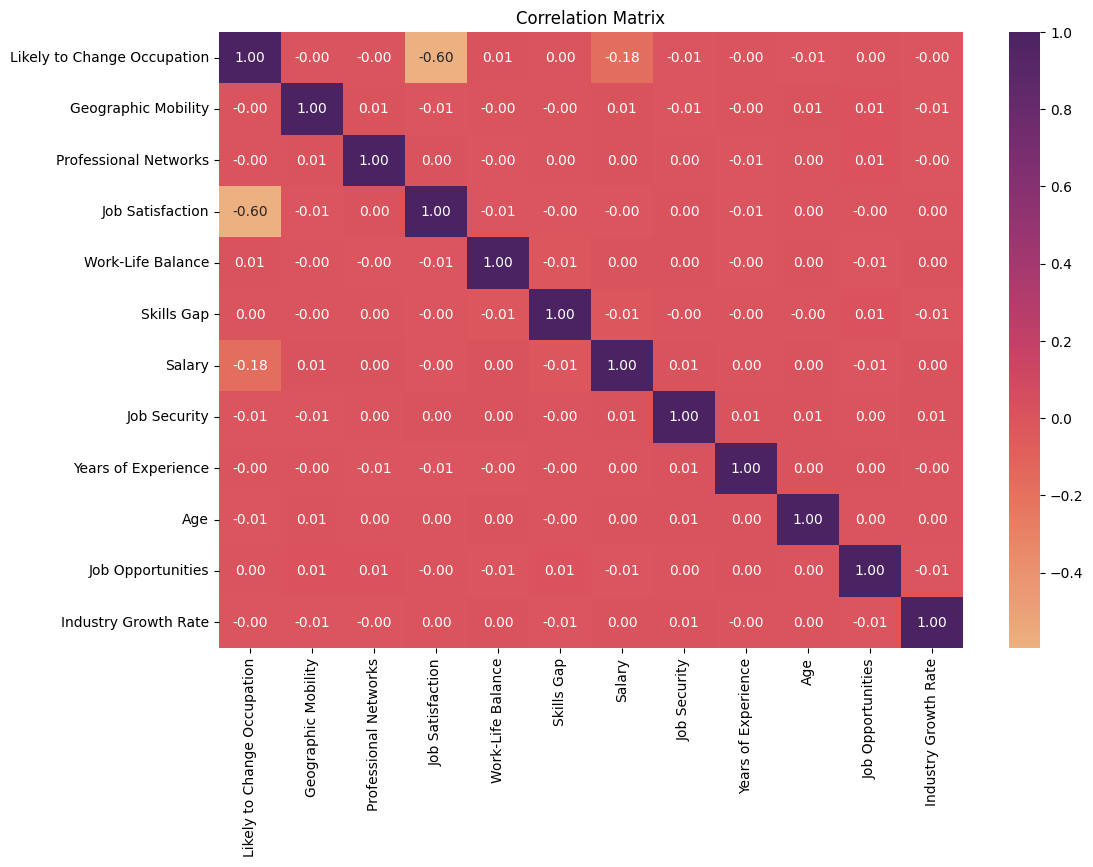

In [352]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f', cmap='flare')
plt.title("Correlation Matrix")
plt.show()

- People who are more likely to change their occupation tend to have **significantly lower job satisfaction** and **lower salary** compared to those who are unlikely to switch jobs.
- This supports the negative correlation observed earlier between **Job Satisfaction**, **Salary** and **Likely to Change Occupation** in the correlation matrix.
- Other box plot looked equal, it would suggest that those features does not differ between those likely and unlikely to change their occupation. This would mean those features are not a key factor in determining someone’s likelihood of changing jobs.

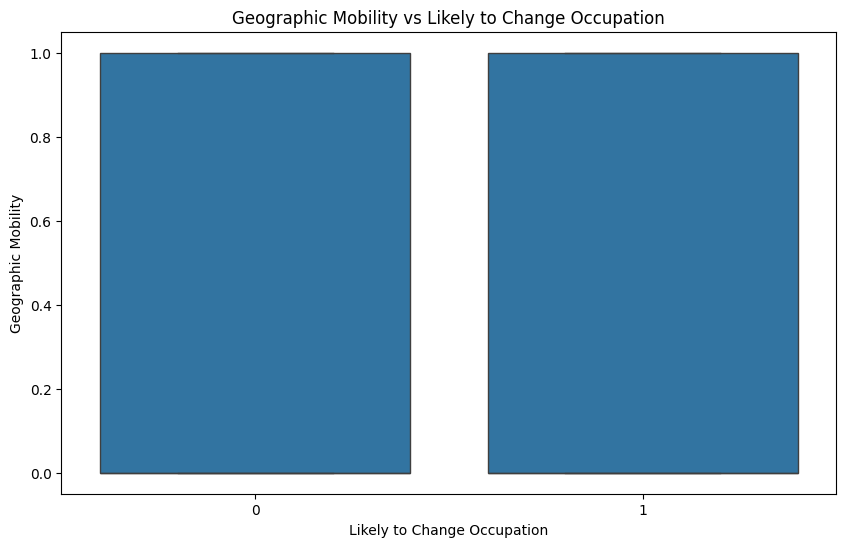

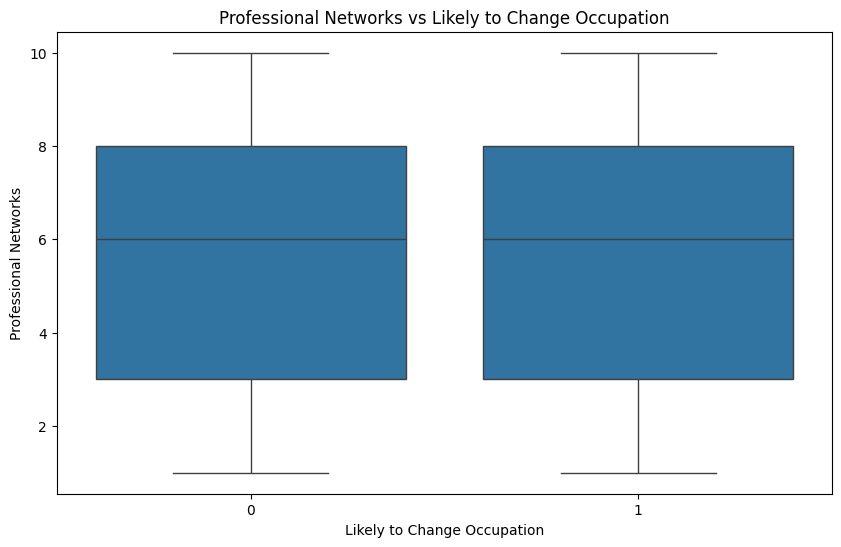

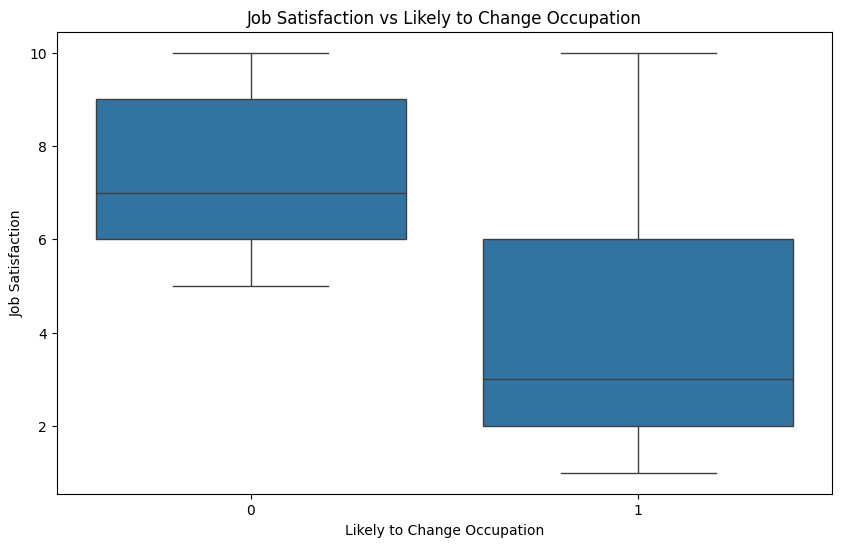

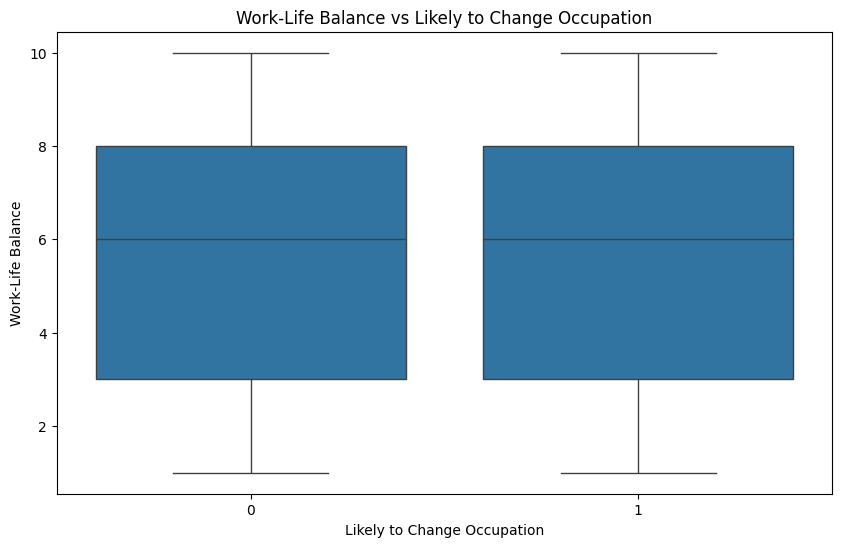

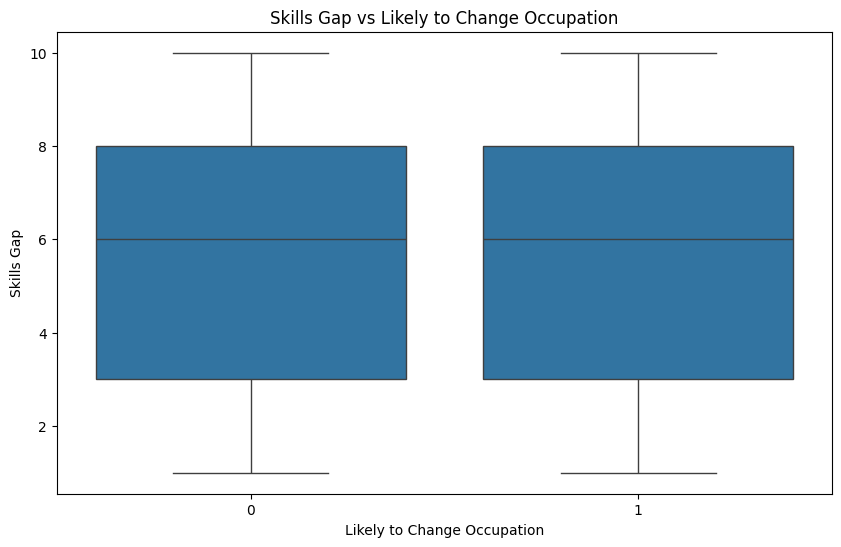

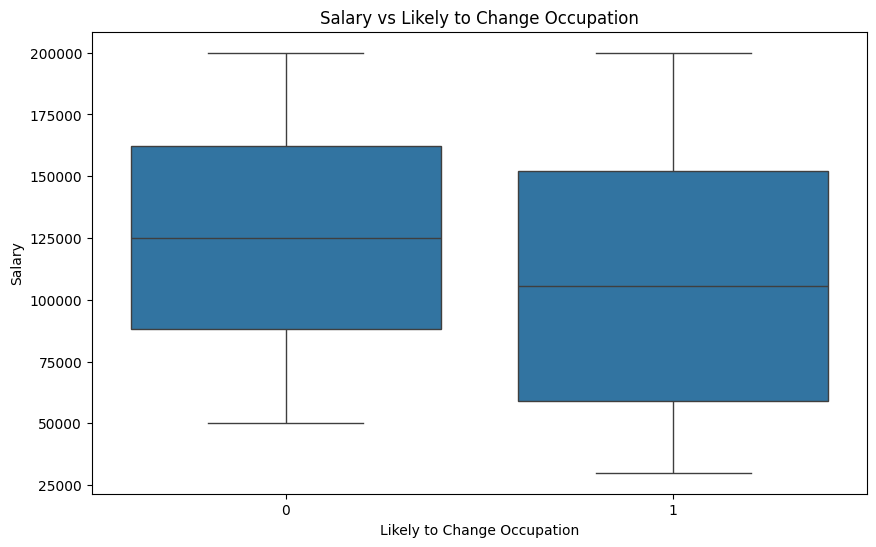

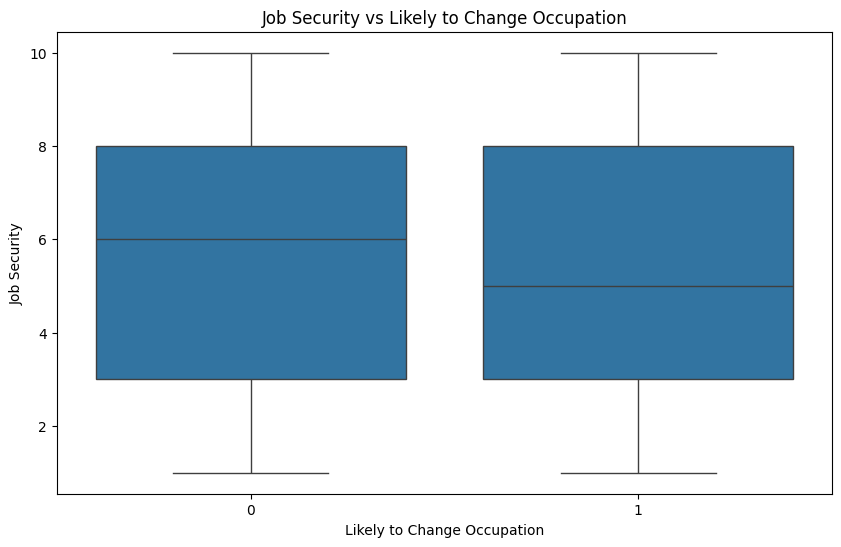

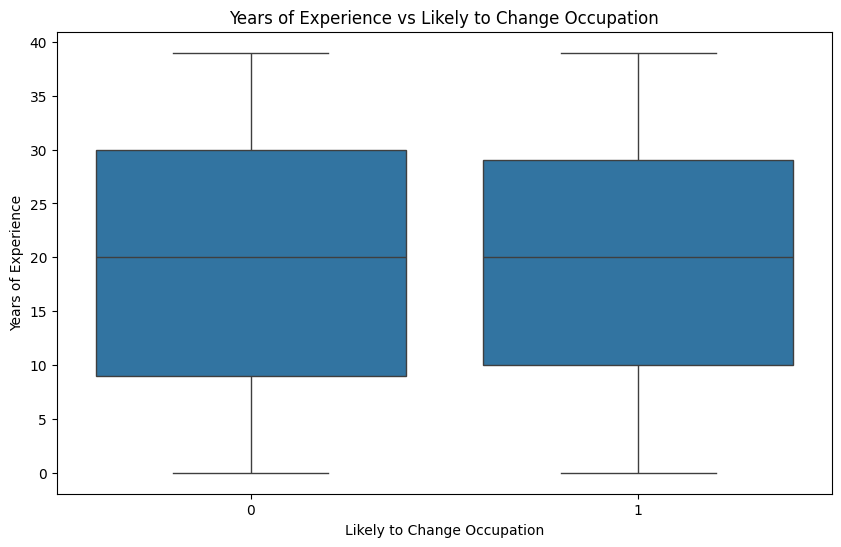

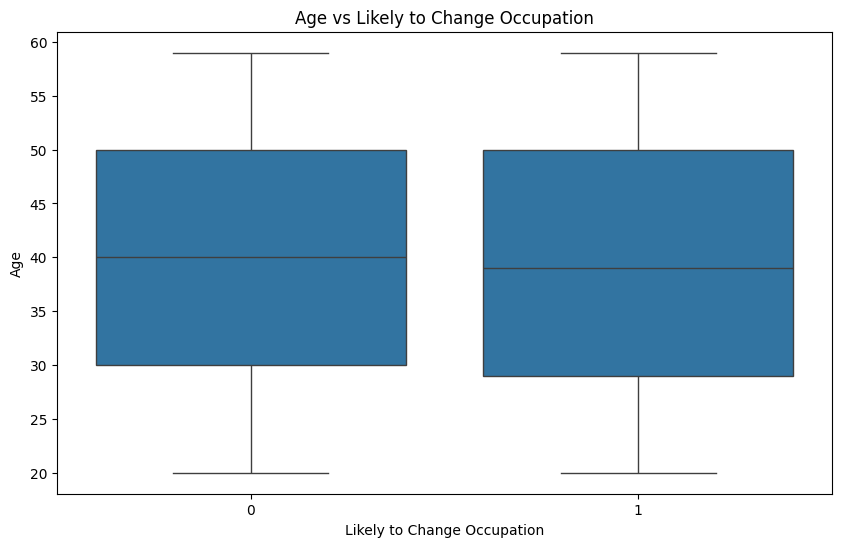

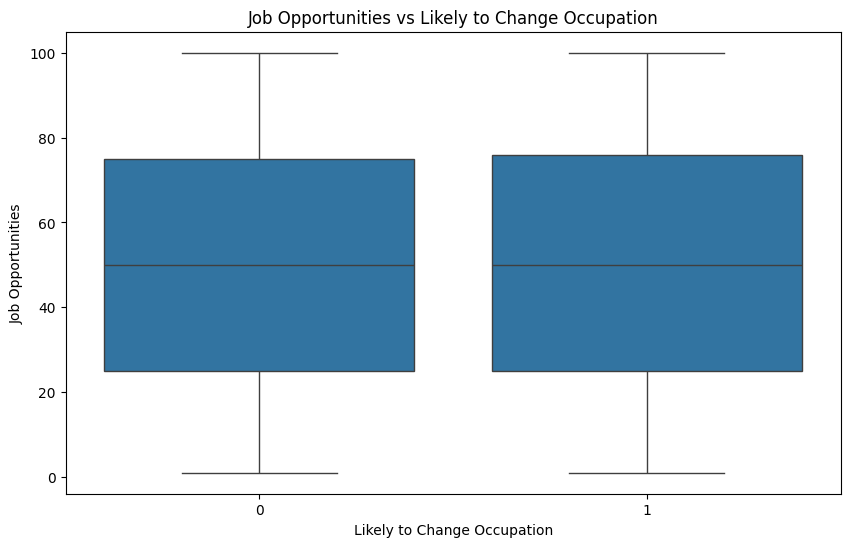

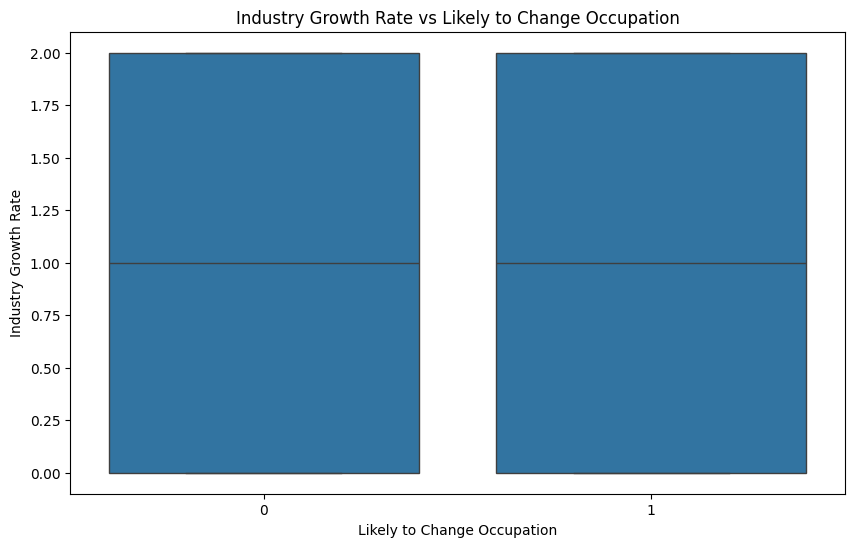

In [353]:
# Box plot to see distributions with the target variable
for col in x.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataset, x='Likely to Change Occupation', y=col)
    plt.title(f'{col} vs Likely to Change Occupation')
    plt.show()

## Data Preparation
- **Handle Missing Data**: There are **no missing values**.
- **Handle Categorical Features**: Mapped ordinal data (industryRate_mapping).
- **Balance the Dataset**: The target variable `Likely to Change Occupation` has a mean of **0.576** indicates a **slight imbalance** toward "Likely to Change Occupation" (1). The imbalance is not severe so it's manageable for decision tree model.
- **Check for Outliers**: None
- **Train-Test Split**: Split data into training and testing sets using train_test_split.
- **Defining Features and Target Variable**: Defined **features (x)** and **target (y)** variables.

In [354]:
# Defining features and target
x = dataset.drop(columns=['Likely to Change Occupation'])  # Independent variables
y = dataset['Likely to Change Occupation']  # Dependent variable

# Splitting data into Training and Testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Modeling

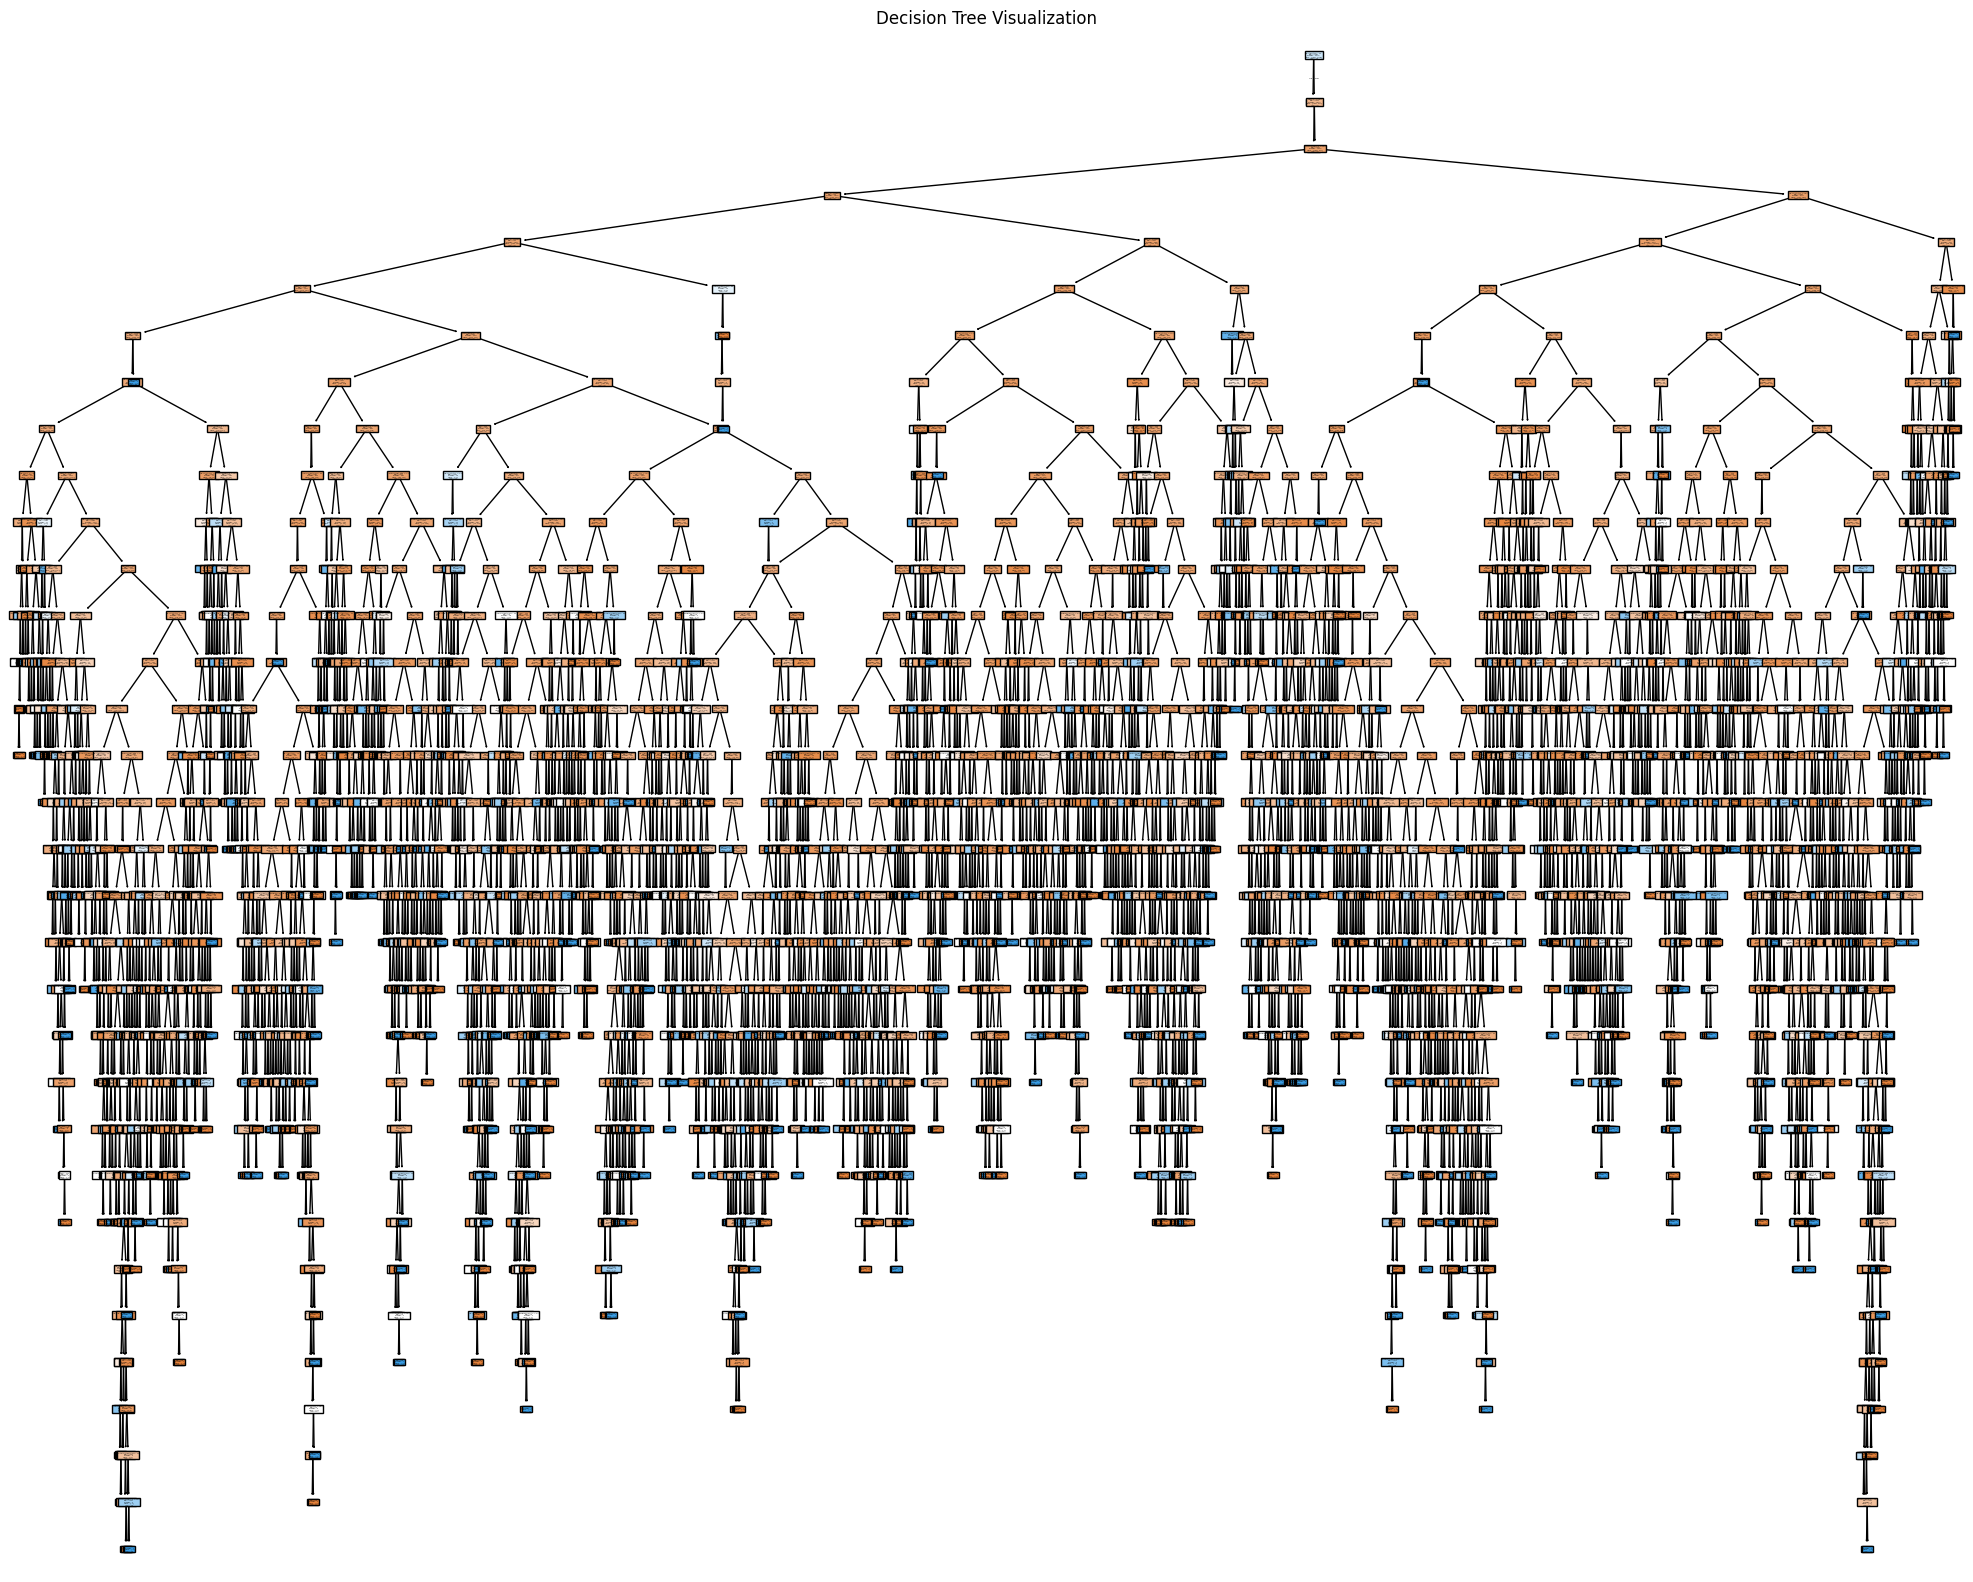

In [355]:
# Train the Decision Tree model
tree = DecisionTreeClassifier(criterion='gini', random_state=42)
tree.fit(x_train, y_train)  

# Visualize the Decision Tree
plt.figure(figsize=(25, 20))
plot_tree(tree, feature_names=x.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [356]:
print(export_text(tree, feature_names=list(x.columns)))

|--- Job Satisfaction <= 4.50
|   |--- class: 1
|--- Job Satisfaction >  4.50
|   |--- Salary <= 50002.50
|   |   |--- class: 1
|   |--- Salary >  50002.50
|   |   |--- Years of Experience <= 25.50
|   |   |   |--- Salary <= 151862.00
|   |   |   |   |--- Salary <= 151673.00
|   |   |   |   |   |--- Salary <= 73280.00
|   |   |   |   |   |   |--- Salary <= 73262.00
|   |   |   |   |   |   |   |--- Job Opportunities <= 88.50
|   |   |   |   |   |   |   |   |--- Salary <= 51688.00
|   |   |   |   |   |   |   |   |   |--- Job Security <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- Work-Life Balance <= 6.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Work-Life Balance >  6.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- Job Security >  2.50
|   |   |   |   |   |   |   |   |   |   |--- Industry Growth Rate <= 1.50
|   |   |   |   |   |   |   |   |   |   |

I used a detailed, **unpruned decision tree** for *training* while relying on a **pruned model** for *interpretability*, considering that the fully-grown tree gives better accuracy.

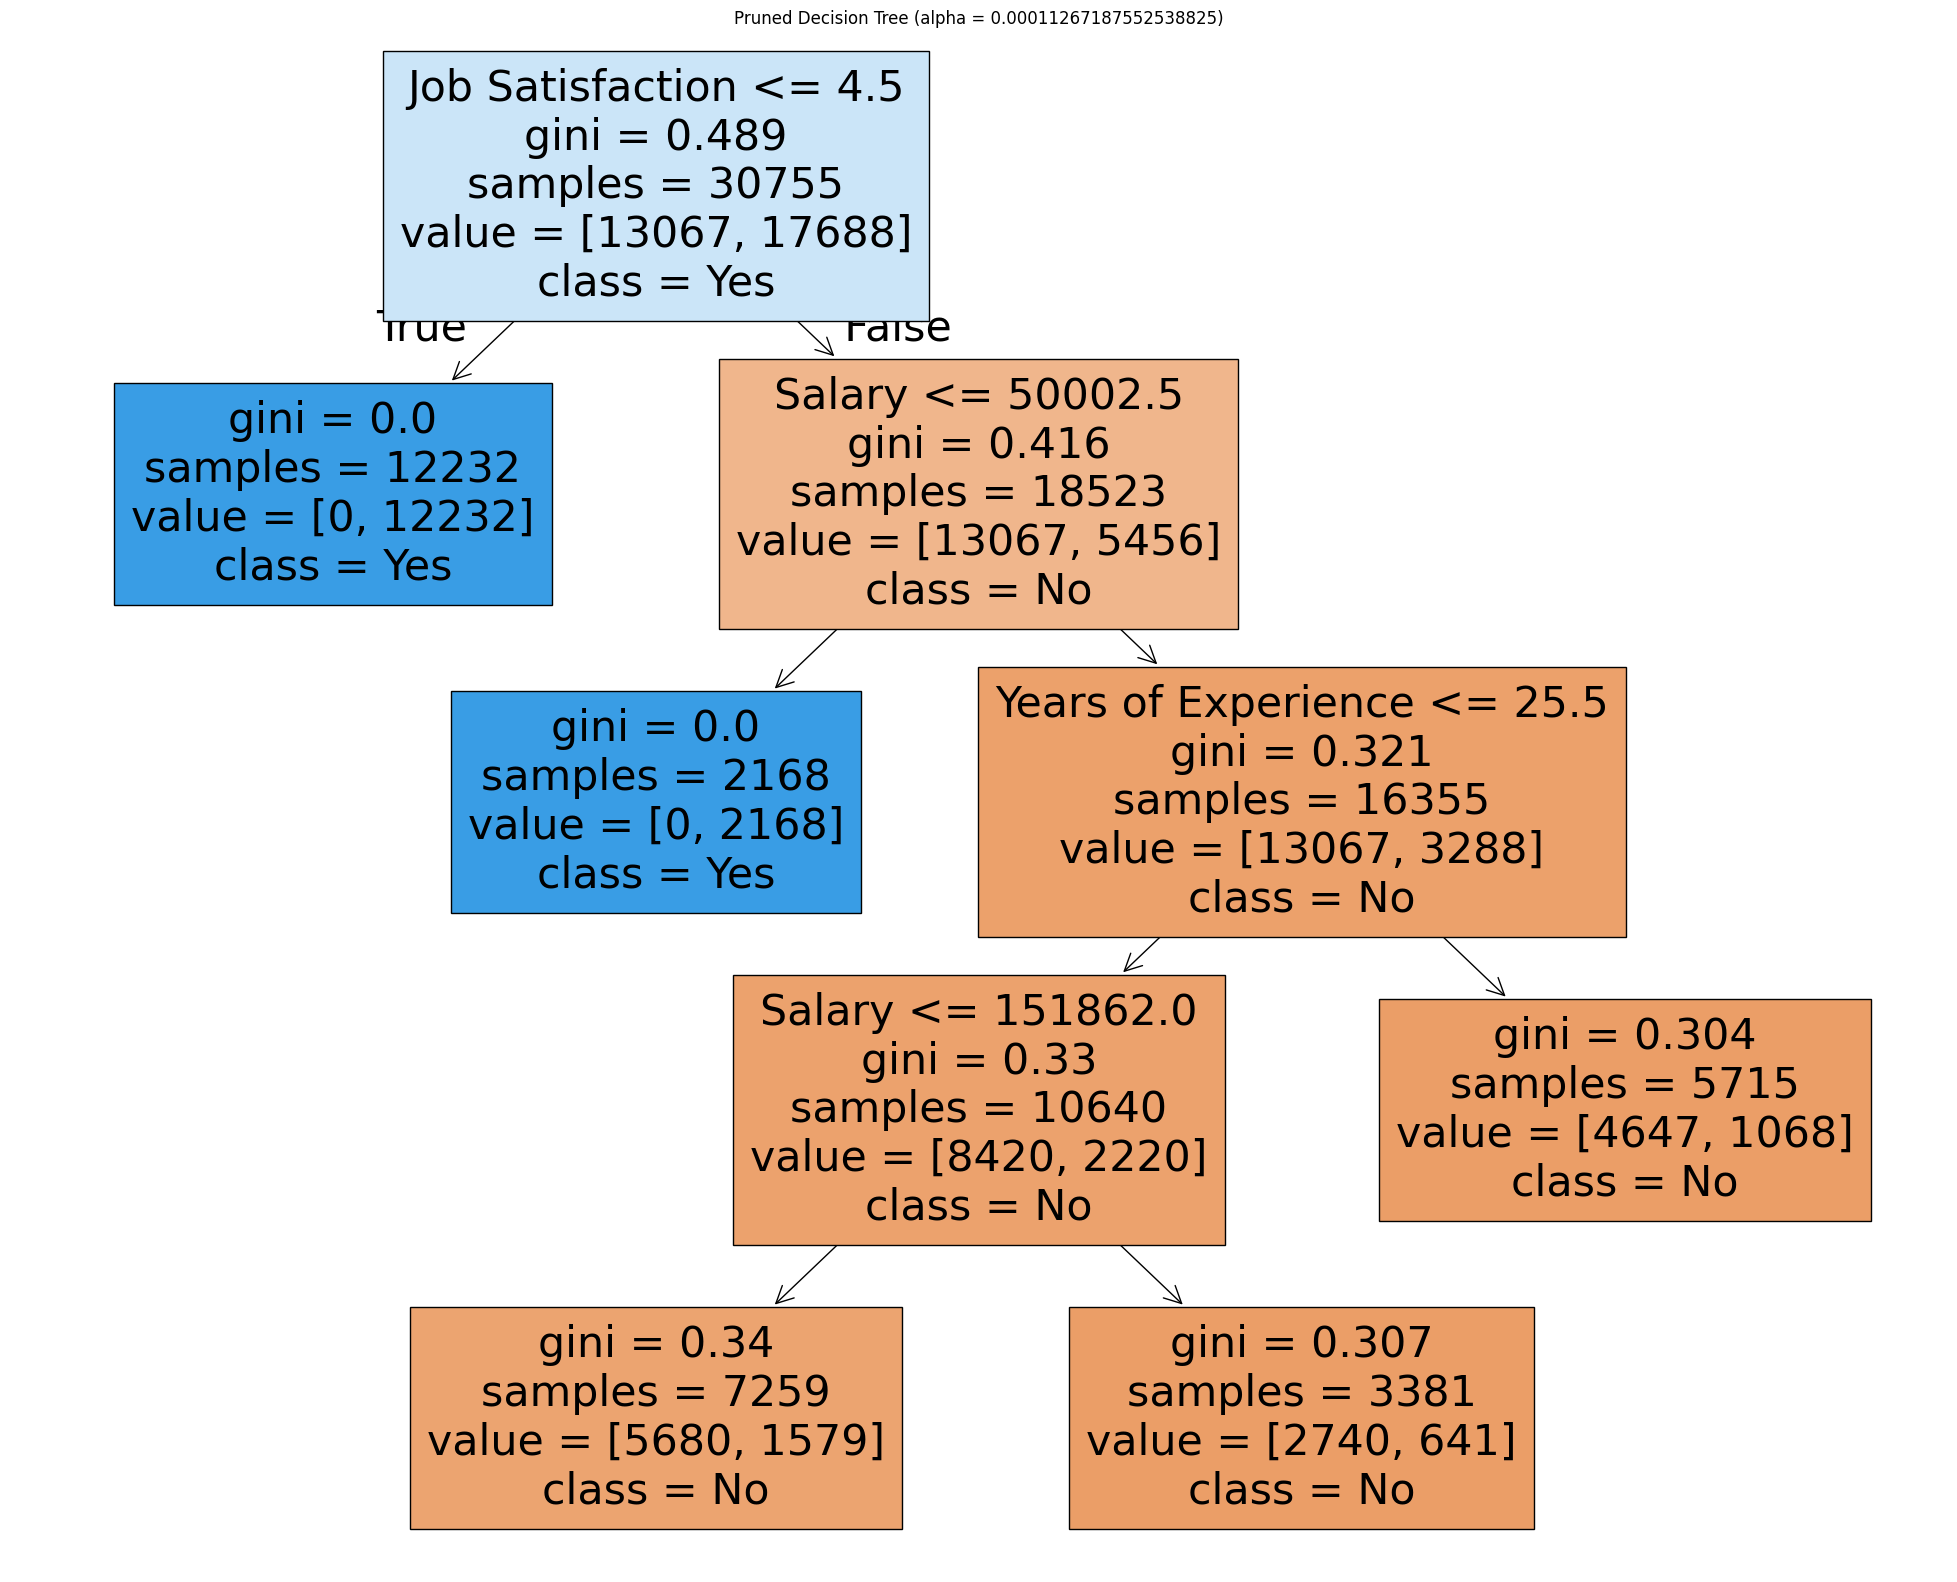

In [357]:
# Post-pruning to simplify the tree after training.
path = tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas

# Use a validation set or cross-validation to find the best alpha (pruning strength)
best_tree = None
best_alpha = 0
best_score = 0

for alpha in ccp_alphas:
    tree_pruned = DecisionTreeClassifier(criterion='gini', random_state=42, ccp_alpha=alpha)
    tree_pruned.fit(x_train, y_train)
    
    score = tree_pruned.score(x_test, y_test)  
    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_tree = tree_pruned

plt.figure(figsize=(25, 20))
plot_tree(best_tree, feature_names=x.columns, class_names=['No', 'Yes'], filled=True)
plt.title(f"Pruned Decision Tree (alpha = {best_alpha})")
plt.show()

In [358]:
print(export_text(best_tree, feature_names=list(x.columns)))

|--- Job Satisfaction <= 4.50
|   |--- class: 1
|--- Job Satisfaction >  4.50
|   |--- Salary <= 50002.50
|   |   |--- class: 1
|   |--- Salary >  50002.50
|   |   |--- Years of Experience <= 25.50
|   |   |   |--- Salary <= 151862.00
|   |   |   |   |--- class: 0
|   |   |   |--- Salary >  151862.00
|   |   |   |   |--- class: 0
|   |   |--- Years of Experience >  25.50
|   |   |   |--- class: 0



In [359]:
# Check Feature Importance
importances = tree.feature_importances_
feature_importances = pd.DataFrame({'Feature': x.columns, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importances:\n", feature_importances)

Feature Importances:
                   Feature  Importance
2        Job Satisfaction    0.507986
5                  Salary    0.226518
9       Job Opportunities    0.051888
8                     Age    0.044761
7     Years of Experience    0.035759
1   Professional Networks    0.031054
4              Skills Gap    0.030630
6            Job Security    0.027360
3       Work-Life Balance    0.023331
10   Industry Growth Rate    0.012588
0     Geographic Mobility    0.008125


- `Job Satisfaction` is the most significant feature, followed by `Salary`.
- The tree breaks the data into smaller subsets based on the conditions at each split, ultimately leading to a predicted class (either 0 or 1).

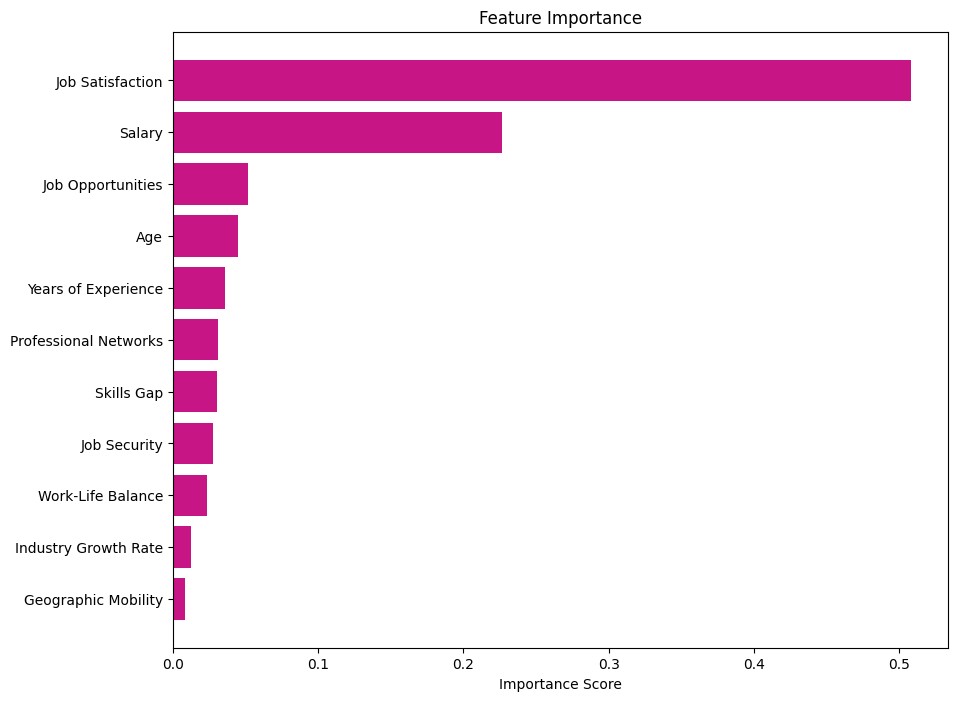

In [360]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='#C71585')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

## Evaluation

- Calculated accuracy using **accuracy_score**.
- Evaluated performance using the **classification report** and **confusion matrix**.

In [361]:
# Make predictions with the best model
y_pred = tree.predict(x_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Display classification report with better readability
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Model Accuracy: 82.16%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.77      0.78      3212
     Class 1       0.84      0.86      0.85      4477

    accuracy                           0.82      7689
   macro avg       0.82      0.81      0.82      7689
weighted avg       0.82      0.82      0.82      7689

Confusion Matrix:
 [[2482  730]
 [ 642 3835]]


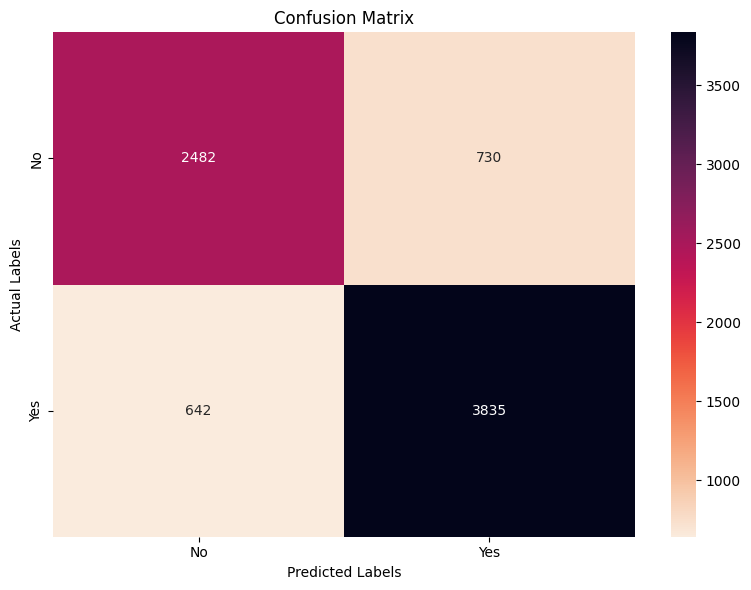

In [362]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket_r', cbar=True, 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout()
plt.show()

In [363]:
y_prob = tree.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_score}")

AUC-ROC: 0.81466383739111


In [364]:
scores = cross_val_score(tree, x_train, y_train, cv=5)
print(f"Cross-Validation Accuracy: {scores.mean()}")

Cross-Validation Accuracy: 0.8220126808649001
